In [1]:
%run notebook_utils.py

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib

# set big font in plots
SMALL_SIZE = 20
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

In [3]:
%cd ..
from langid import WrappedVectorizer, np_sanitize, sanitize
%cd -

/Users/Lin/git/SwigSpot/language-detection
/Users/Lin/git/SwigSpot/language-detection/notebooks


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.optimizers import SGD
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


# Features

In [5]:
X_train, X_test, y_train, y_test = load_split_data()
sms_any_X, sms_any_y = load_sms_any()
X_valid, y_valid = load_validation_data()

# Neural Net -- First attempt

In this first attempt, we use features from Swiss German only and limit the feature vector to 1000 trigrams. 

The model has only one hidden layerThe number of iterations is 50.

In [6]:
ngram_range = (3,3)
num_features = 1000

# create the vectorizer
vectorizer = WrappedVectorizer(analyzer='char', ngram_range=ngram_range, sg_only=True, sanitizer=np_sanitize,
                             max_features=num_features, sublinear_tf=True, use_idf=True, norm='l2')

# create the features for training
X = vectorizer.fit_transform(X_train, y_train)

In [7]:
# create model
hidden_size = 500
output_size = len(langs)

model = Sequential()
# using sigmoid vs relu, get got:
#   loss=1.5869, accuracy: 59.4286% and 10660 errors on SMS... => relu is better
model.add(Dense(hidden_size, input_dim=num_features, activation='relu')) # hidden layer: same #neurons as input layer
model.add(Dense(output_size, activation='sigmoid')) # output layer: one for each language
model.add(Activation("softmax")) # add probabilities to the class output

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2505      
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 503,005
Trainable params: 503,005
Non-trainable params: 0
_________________________________________________________________


In [8]:
# train the model using SGD
print("[INFO] compiling model...")
sgd = SGD(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])
model.fit(X, y_train, epochs=50, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/50
29551/29551 [==============================] - 1s 37us/step - loss: 1.6086 - acc: 0.2580
Epoch 2/50
29551/29551 [==============================] - 1s 34us/step - loss: 1.6064 - acc: 0.3502
Epoch 3/50
29551/29551 [==============================] - 1s 37us/step - loss: 1.6041 - acc: 0.4380
Epoch 4/50
29551/29551 [==============================] - 1s 35us/step - loss: 1.6018 - acc: 0.5261
Epoch 5/50
29551/29551 [==============================] - 1s 35us/step - loss: 1.5994 - acc: 0.6002
Epoch 6/50
29551/29551 [==============================] - 1s 39us/step - loss: 1.5969 - acc: 0.6661
Epoch 7/50
29551/29551 [==============================] - 1s 43us/step - loss: 1.5943 - acc: 0.7152
Epoch 8/50
29551/29551 [==============================] - 1s 38us/step - loss: 1.5915 - acc: 0.7480
Epoch 9/50
29551/29551 [==============================] - 1s 38us/step - loss: 1.5886 - acc: 0.7739
Epoch 10/50
29551/29551 [==============================] - 1s 39us/step - 

[INFO] evaluating on testing set...
7388/7388 [==============================] - 0s 24us/step
[INFO] loss=1.2734, accuracy: 96.3048%


Testing recall on SMS:

total samples    10692
total errors       373 (3.49%)
---------------------------------
languages detected
    de      319
    fr        9
    en       20
    it       25
    sg    10319


Validate using the leipzig validation set:

accuracy: 0.9537

             precision    recall  f1-score   support

         de     0.9076    0.9583    0.9322      2613
         fr     0.9830    0.9744    0.9787      2613
         en     0.9842    0.9533    0.9685      2613
         it     0.9896    0.9816    0.9856      2613
         sg     0.9078    0.9009    0.9043      2613

avg / total     0.9544    0.9537    0.9539     13065



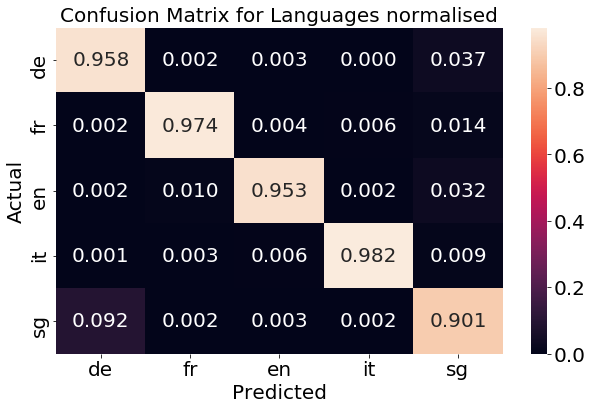

In [9]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(vectorizer.transform(X_test), y_test, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

print("\n\nTesting recall on SMS:\n")
sms_predicted = model.predict(vectorizer.transform(sms_sg)).argmax(axis=1)
eval_recall_sms(sms_predicted)

print("\n\nValidate using the leipzig validation set:\n")
valid_predicted = model.predict(vectorizer.transform(X_valid)).argmax(axis=1)
print_results(y_valid, valid_predicted)
plot_confusion_matrix(y_valid, valid_predicted, normalised=True)

# Another attempt

In [10]:
ngram_range2 = (3,3)
num_features2 = 6000

# create the vectorizer
vectorizer2 = WrappedVectorizer(analyzer='char', ngram_range=ngram_range2, sg_only=False, sanitizer=np_sanitize,
                             max_features=num_features2, sublinear_tf=True, use_idf=True, norm='l2')

# create the features for training
X2 = vectorizer2.fit_transform(X_train, y_train)

In [11]:
# create model

hidden_size2_1 = 2000
hidden_size2_2 = 500
output_size2 = len(langs)

model2 = Sequential()
# using sigmoid vs relu, get got:
#   loss=1.5869, accuracy: 59.4286% and 10660 errors on SMS... => relu is better
model2.add(Dense(hidden_size2_1, input_dim=num_features2, activation='relu')) 
model2.add(Dense(hidden_size2_2, input_dim=hidden_size2_1, activation='relu')) 
model2.add(Dense(output_size2, activation='sigmoid')) 
model2.add(Activation("softmax")) # add probabilities to the class output

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2000)              12002000  
_________________________________________________________________
dense_4 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2505      
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 13,005,005
Trainable params: 13,005,005
Non-trainable params: 0
_________________________________________________________________


In [12]:
# train the model using SGD
print("[INFO] compiling model...")
model2.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])
model2.fit(X2, y_train, epochs=10, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/10
29551/29551 [==============================] - 24s 823us/step - loss: 1.6088 - acc: 0.2215
Epoch 2/10
29551/29551 [==============================] - 24s 820us/step - loss: 1.6079 - acc: 0.2732
Epoch 3/10
29551/29551 [==============================] - 25s 846us/step - loss: 1.6069 - acc: 0.3395
Epoch 4/10
29551/29551 [==============================] - 24s 807us/step - loss: 1.6059 - acc: 0.4483
Epoch 5/10
29551/29551 [==============================] - 25s 830us/step - loss: 1.6048 - acc: 0.51752s - loss
Epoch 6/10
29551/29551 [==============================] - 24s 806us/step - loss: 1.6036 - acc: 0.5604
Epoch 7/10
29551/29551 [==============================] - 24s 823us/step - loss: 1.6023 - acc: 0.6150
Epoch 8/10
29551/29551 [==============================] - 25s 843us/step - loss: 1.6009 - acc: 0.6762
Epoch 9/10
29551/29551 [==============================] - 25s 849us/step - loss: 1.5993 - acc: 0.7298
Epoch 10/10
29551/29551 [======================

[INFO] evaluating on testing set...
7388/7388 [==============================] - 1s 188us/step
[INFO] loss=1.5967, accuracy: 76.5972%


Testing recall on SMS:

total samples    10692
total errors      4688 (43.85%)
---------------------------------
languages detected
    de     4619
    fr        3
    en       66
    it     6004


Validate using the leipzig validation set:

accuracy: 0.7711

             precision    recall  f1-score   support

         de     0.5280    0.9633    0.6821      2613
         fr     0.9979    0.7145    0.8327      2613
         en     0.9988    0.6464    0.7849      2613
         it     0.9224    0.9728    0.9469      2613
         sg     0.7374    0.5587    0.6358      2613

avg / total     0.8369    0.7711    0.7765     13065



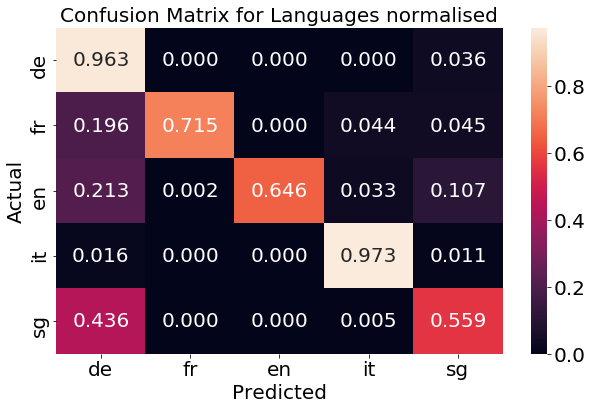

In [13]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model2.evaluate(vectorizer2.transform(X_test), y_test, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

print("\n\nTesting recall on SMS:\n")
sms_predicted = model2.predict(vectorizer2.transform(sms_sg)).argmax(axis=1)
eval_recall_sms(sms_predicted)

print("\n\nValidate using the leipzig validation set:\n")
valid_predicted = model2.predict(vectorizer2.transform(X_valid)).argmax(axis=1)
print_results(y_valid, valid_predicted)
plot_confusion_matrix(y_valid, valid_predicted, normalised=True)

# Yet another attempt

In [14]:
ngram_range3 = (3,3)
num_features3 = 3000

# create the vectorizer
vectorizer3 = WrappedVectorizer(analyzer='char', ngram_range=ngram_range3, sg_only=False,
                             max_features=num_features3, sublinear_tf=True, use_idf=True, norm='l2')

# create the features for training
X3 = vectorizer3.fit_transform(X_train, y_train)

In [15]:
# create model

hidden_size3_1 = 3000
#hidden_size3_2 = 50
output_size3 = len(langs)

model3 = Sequential()
# using sigmoid vs relu, get got:
#   loss=1.5869, accuracy: 59.4286% and 10660 errors on SMS... => relu is better
model3.add(Dense(hidden_size3_1, input_dim=num_features3, activation='relu')) 
#model3.add(Dense(hidden_size3_2, input_dim=hidden_size3_1, activation='relu')) 
model3.add(Dense(output_size3, activation='sigmoid')) 
model3.add(Activation("softmax")) # add probabilities to the class output

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 3000)              9003000   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 15005     
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0         
Total params: 9,018,005
Trainable params: 9,018,005
Non-trainable params: 0
_________________________________________________________________


In [16]:
# train the model using SGD
print("[INFO] compiling model...")
model3.compile(loss="sparse_categorical_crossentropy", optimizer=SGD(lr=0.01), metrics=["accuracy"])
model3.fit(X3, y_train, epochs=50, batch_size=128, verbose=1)

[INFO] compiling model...
Epoch 1/50
29551/29551 [==============================] - 14s 478us/step - loss: 1.6086 - acc: 0.2841
Epoch 2/50
29551/29551 [==============================] - 15s 495us/step - loss: 1.6072 - acc: 0.4131
Epoch 3/50
29551/29551 [==============================] - 15s 516us/step - loss: 1.6059 - acc: 0.5455
Epoch 4/50
29551/29551 [==============================] - 14s 459us/step - loss: 1.6045 - acc: 0.6646
Epoch 5/50
29551/29551 [==============================] - 16s 541us/step - loss: 1.6030 - acc: 0.7496
Epoch 6/50
29551/29551 [==============================] - 16s 555us/step - loss: 1.6016 - acc: 0.8087
Epoch 7/50
29551/29551 [==============================] - 16s 525us/step - loss: 1.6001 - acc: 0.8496
Epoch 8/50
29551/29551 [==============================] - 14s 470us/step - loss: 1.5985 - acc: 0.8734
Epoch 9/50
29551/29551 [==============================] - 14s 486us/step - loss: 1.5969 - acc: 0.8938
Epoch 10/50
29551/29551 [==============================]

[INFO] evaluating on testing set...
7388/7388 [==============================] - 1s 134us/step
[INFO] loss=1.4012, accuracy: 98.2133%


Testing recall on SMS:

total samples    10692
total errors       388 (3.63%)
---------------------------------
languages detected
    de      364
    fr        7
    en        6
    it       11
    sg    10304


Validate using the leipzig validation set:

accuracy: 0.9719

             precision    recall  f1-score   support

         de     0.9044    0.9809    0.9411      2613
         fr     0.9977    0.9946    0.9962      2613
         en     0.9962    0.9920    0.9941      2613
         it     0.9969    0.9989    0.9979      2613
         sg     0.9701    0.8932    0.9301      2613

avg / total     0.9730    0.9719    0.9719     13065



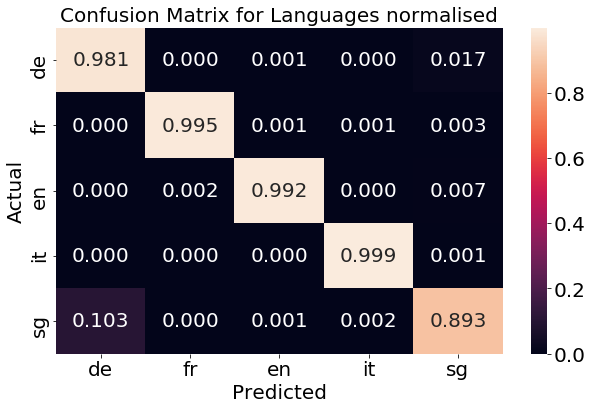

In [17]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model3.evaluate(vectorizer3.transform(X_test), y_test, batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

print("\n\nTesting recall on SMS:\n")
sms_predicted = model3.predict(vectorizer3.transform(sms_sg)).argmax(axis=1)
eval_recall_sms(sms_predicted)

print("\n\nValidate using the leipzig validation set:\n")
valid_predicted = model3.predict(vectorizer3.transform(X_valid)).argmax(axis=1)
print_results(y_valid, valid_predicted)
plot_confusion_matrix(y_valid, valid_predicted, normalised=True)